In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [5]:
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as ani
import importlib
import os
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [3]:
import matplotlib as mpl
plt.style.use(['dark_background'])
mpl.rcParams['axes.facecolor'] = (27/256, 27/256, 27/256)
mpl.rcParams['figure.facecolor'] = (27/256, 27/256, 27/256)
mpl.rcParams['legend.facecolor'] = (50/256, 50/256, 50/256)
mpl.rcParams['savefig.facecolor'] = (27/256, 27/256, 27/256)

In [69]:
# model_path = "2021-04-30_18h-39m-50s" 
model_path = "2021-08-06_02h-36m-58s"
model_version = "checkpoints/model-0"

spec = importlib.util.spec_from_file_location("lapd_ebm_copy", "experiments/" + model_path + "/lapd_ebm_copy.py")
lapd_ebm = importlib.util.module_from_spec(spec)
spec.loader.exec_module(lapd_ebm)
sample_langevin = lapd_ebm.sample_langevin
sample_langevin_cuda = lapd_ebm.sample_langevin_cuda
ReplayBuffer = lapd_ebm.ReplayBuffer
model = lapd_ebm.NeuralNet().cuda()
ckpt = torch.load("experiments/" + model_path + "/" + model_version + ".pt")
model.load_state_dict(ckpt['model_state_dict'], strict=False)
data = torch.tensor(np.load("data/isat_downsampled_8_div3.npz")['arr_0'].reshape(-1, 10)).float()
# data = torch.tensor(np.load("data/isat_downsampled_8.npz")['arr_0'].reshape(-1, 10)).float()
replay_buffer = ReplayBuffer(ckpt['replay_buffer_list'].shape[0], np.random.randn(*data.shape))
replay_buffer.sample_list = ckpt['replay_buffer_list']
print("Number of parameters: {}".format(np.sum([p.numel() for p in model.parameters() if p.requires_grad])))

Number of parameters: 47889


In [70]:
n_samp = 2000
step_size = 1e-2

rand_num = torch.cat((torch.randn((n_samp, 1))*1,
                      torch.randn((n_samp, 1))*1,
                      torch.randn((n_samp, 8), requires_grad=True)*1), 1)
data.requires_grad=True
# torch.tensor(replay_buffer.sample_list[0:n_samp], requires_grad=True).float()
temp_buffer = ReplayBuffer(8192, np.random.randn(8192, 10))
for i in range(200):
    buf_samp = temp_buffer.sample(int(256 * 0.98))
    buf_rand = np.random.randn(256 - buf_samp.shape[0], 10)
    buf_samp = np.concatenate([buf_samp, buf_rand], axis=0)
    buf_samp = torch.Tensor(buf_samp).cuda().requires_grad_()
    samples = sample_langevin(buf_samp, model, step_size=step_size, sample_steps=10, noise_scale=0.05, return_list=False)
    temp_buffer.add(samples)
samples = sample_langevin(torch.Tensor(temp_buffer.sample_list).cuda().requires_grad_(), model, step_size=step_size,
                          sample_steps=25, noise_scale=0.05, return_list=False)
# temp_buffer.add(samples)
# buf_samp = temp_buffer.sample(n_samp)
buf_samp = samples[:n_samp].detach().cpu().numpy()

<IPython.core.display.Javascript object>


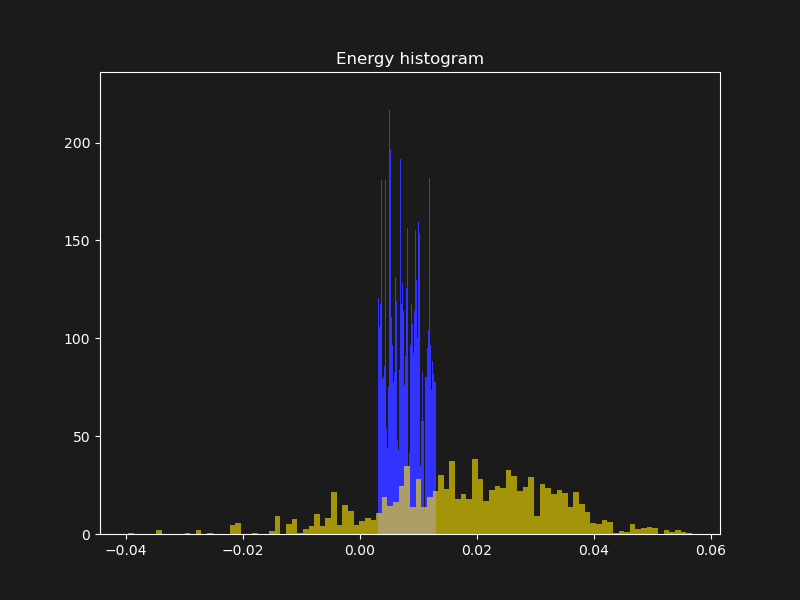

In [71]:
fig, axes = plt.subplots(1, 1, figsize=(8,6))
plt.title('Energy histogram')
axes.hist(model(data.cuda()).cpu().detach().numpy(), bins=100, density=True, color=(0.2, 0.2, 1.0, 1.0));
# axes.hist(model(torch.Tensor(replay_buffer.sample_list[:400]).cuda()).cpu().detach().numpy(), bins=100, density=True,
#                color=(0, 0.9, 0.0, 0.6));
axes.hist(model(torch.Tensor(buf_samp).cuda()).cpu().detach().numpy(), bins=100, density=True,
               color=(1.0, 0.9, 0.0, 0.6));
plt.savefig("experiments/" + model_path + '/energy_hist.png', facecolor=(27/256, 27/256, 27/256))

<IPython.core.display.Javascript object>


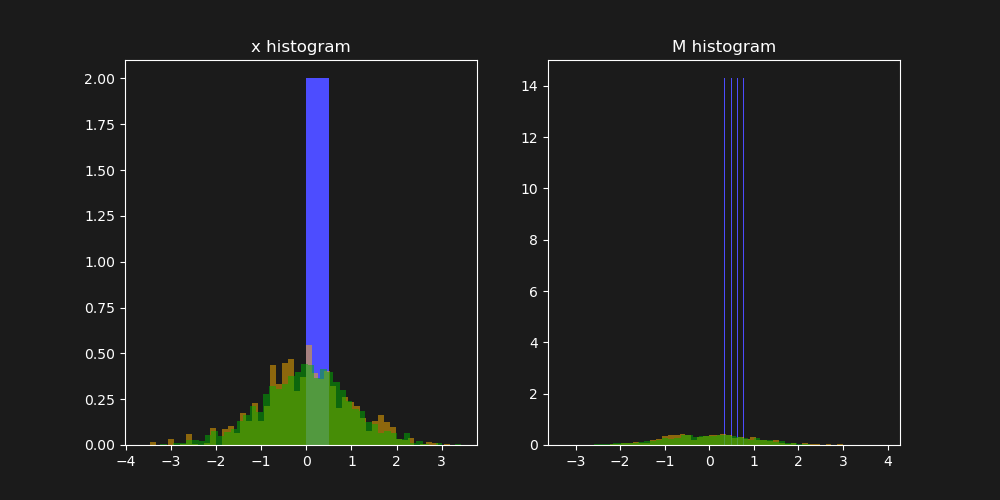

Text(0.5, 1.0, 'M histogram')

In [72]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.hist(data.detach().numpy()[:, 0], bins=101, density=True, color=(0.3, 0.3, 1.0, 1.0));
ax1.hist(buf_samp[:, 0], bins=50, density=True, color=(1.0, 0.7, 0, 0.5));
ax1.hist(replay_buffer.sample_list[:, 0], bins=50, color=(0, 0.7, 0, 0.5), density=True);
ax2.hist(data.detach().numpy()[:, 1], bins=40, density=True, color=(0.3, 0.3, 1.0, 1.0));
ax2.hist(buf_samp[:, 1], bins=50, density=True, color = (1.0, 0.7, 0, 0.5));
ax2.hist(replay_buffer.sample_list[:, 1], bins=50, color=(0, 0.7, 0, 0.5), density=True);
ax1.set_title('x histogram')
ax2.set_title('M histogram')
plt.savefig("experiments/" + model_path + '/xM_hist.png', facecolor=(27/256, 27/256, 27/256))

<IPython.core.display.Javascript object>


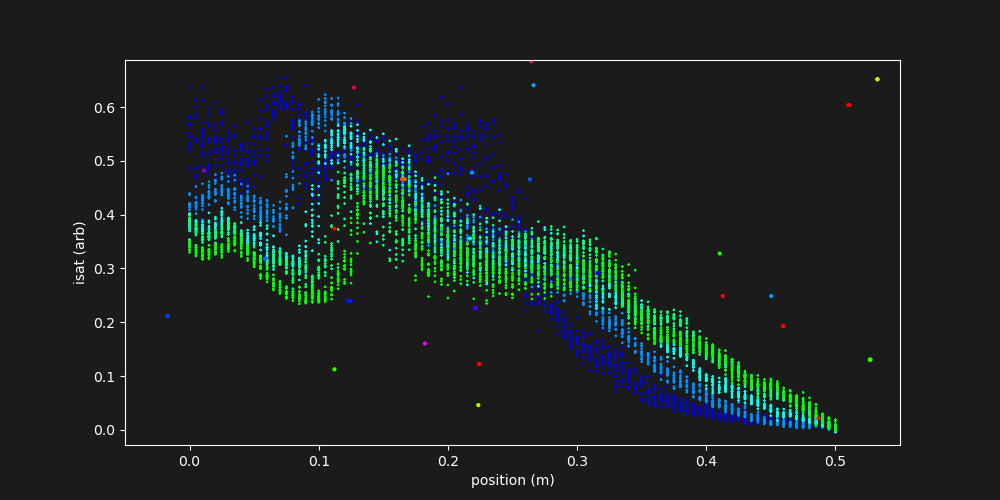

In [73]:
fig = plt.figure(figsize=(10,5))
ax = plt.axes()

num_plot_samp = 600

data_size = data.detach().numpy()[:, 1].shape[0]
data_scaled_color = (1-(data.detach().numpy()[:, 1:2] * 3 - 1) / 1.68) / 3 + 1 / 3
data_scaled_color = np.concatenate([data_scaled_color,
                                    np.ones((data_size, 1)), np.ones((data_size, 1))], axis=1)
samp_scaled_color = (((buf_samp[:n_samp, 1:2] * 3 - 1) / 1.68) / 3 + 5/6)
for i in range(n_samp):
    if samp_scaled_color[i] > 1:
        samp_scaled_color[i] -= 1
samp_scaled_color = np.clip(np.concatenate([samp_scaled_color,
                                    np.ones((n_samp, 1)), np.ones((n_samp, 1))], axis=1), 0, 1)


data_scat = ax.scatter(data.detach().numpy()[:, 0], data.detach().numpy()[:, 2],  marker='x', s=1,
                       color=mpl.colors.hsv_to_rgb(data_scaled_color))
sample_scat = ax.scatter(buf_samp[:num_plot_samp, 0],
                         buf_samp[:num_plot_samp, 2], s=4,color=mpl.colors.hsv_to_rgb(samp_scaled_color)[:num_plot_samp])
ax.set_ylim(np.min(data.detach().numpy()[:, 2:]), np.max(data.detach().numpy()[:, 2:]))


# samp_scaled_color = 

def animate(i):
    data_scat.set_offsets(np.hstack((data.detach().numpy()[:, 0, np.newaxis],
                                data.detach().numpy()[:, 2+i, np.newaxis])))
    sample_scat.set_offsets(np.hstack((buf_samp[:num_plot_samp, 0, np.newaxis],
                                buf_samp[:num_plot_samp, 2+i, np.newaxis])))
fig.set_facecolor((27/256, 27/256, 27/256))
ax.set_facecolor((27/256, 27/256, 27/256))
plt.xlabel('position (m)')
plt.ylabel('isat (arb)')
plt.xlim(-0.05, 0.55)
# plt.legend()

anim = ani.FuncAnimation(fig, animate, frames=8, interval=250, blit=True, repeat=True)
anim.save("experiments/" + model_path + '/scatter_ani.mp4', savefig_kwargs={'facecolor': (27/256, 27/256, 27/256)})

In [29]:
i

572

In [18]:
datafiles = ["data/3-line_500G_isat.npz",
             "data/3-line_750G_isat.npz",
             "data/3-line_1000G_isat.npz",
             "data/3-line_1250G_isat.npz",
             "data/3-line_1500G_isat.npz"]
n = []
for f in datafiles: 
    n.append(np.load(f)['isat'].reshape(101, 15, -1)/1e11/3)
n = np.array(n).reshape(7575, -1)

In [51]:
buf_samp[i+1, 1].item()*3

1.701797068119049

In [52]:
buf_samp[i+1, 0].item()

0.3344529867172241

<IPython.core.display.Javascript object>


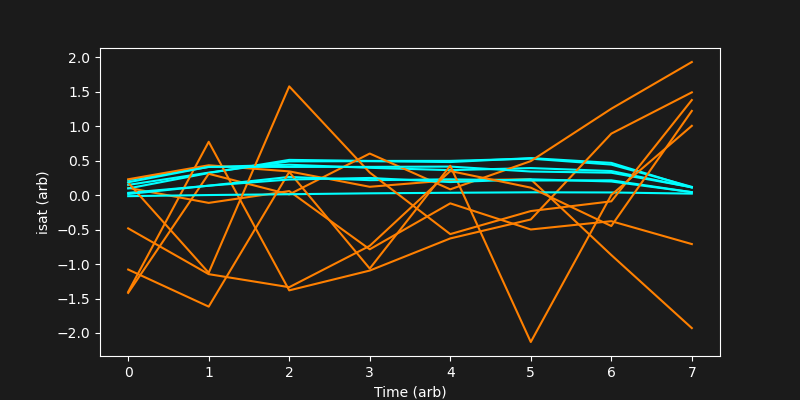

In [74]:
# data_index = 2*101*15+15*67
plt.figure(figsize=(8, 4))
for i in np.random.randint(0, high=2000, size=7): #[572]: 
#     plt.plot(data.detach()[i][2:])
#     plt.plot(np.linspace(0,7,3136), n[i], color=(0.0, 0.4, 1.0, 1.0), label="Data")
    plt.plot(data.detach()[i][2:], color=(0.0, 1.0, 1.0, 1.0), label="Data (downsampled)")
    plt.plot(buf_samp[i][2:], color=(1.0, 0.5, 0.0, 1.0), label="Sampled")
    plt.title("")
#     plt.tight_layout()
    plt.xlabel("Time (arb)")
    plt.ylabel("isat (arb)")
#     plt.legend()
#     plt.savefig('time-series-example.png')
plt.savefig("experiments/" + model_path + '/time_series.png', facecolor=(27/256, 27/256, 27/256))

<IPython.core.display.Javascript object>


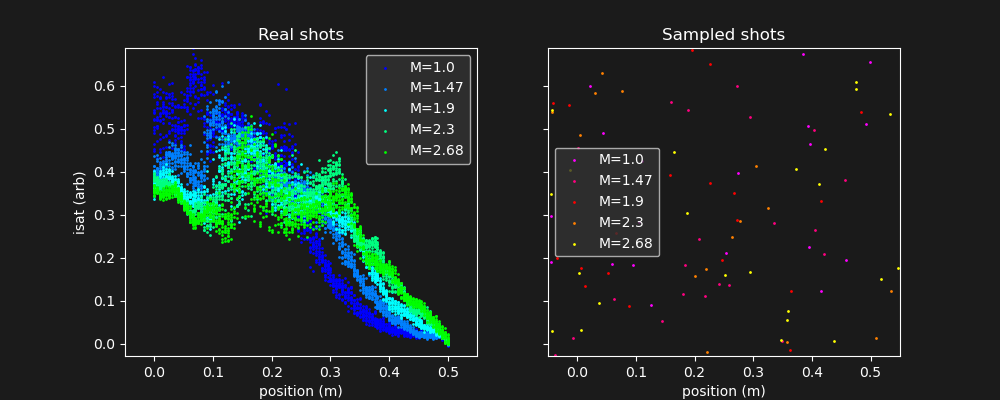

In [68]:
n_samp_cond = 300
cndstp = 1e-2
cnd_stps = 120

data.requires_grad=True

range_nums = [0, 1, 2, 3, 4]

rand_nums = []
B_fields = [1/3, 1.47/3, 1.9/3, 2.3/3, 2.68/3]
for i in range(5):
    rand_nums.append(torch.cat((torch.randn((n_samp_cond, 1)),
                      torch.randn((n_samp_cond, 1))*0+B_fields[i],
                      torch.randn((n_samp_cond, 8), requires_grad=True)), 1))
samples_cond = []
for i in range(5):
    samples_cond.append(sample_langevin(rand_nums[i].cuda()[0:n_samp_cond],
                          model, step_size=torch.Tensor([cndstp, 0, cndstp, cndstp, cndstp, cndstp,
                                                         cndstp, cndstp, cndstp, cndstp]).cuda(),
                          sample_steps=cnd_stps, noise_scale=0.01, return_list=False))

# for i in range(len(samples)):
#     samples[i].cpu()

t_ini = 2
t_end = 3
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), sharey=True)
# ax = plt.axes()

# data_colors = [(0, 0, 1, 0.8), (0, 0.3, 1.0, 0.8), (0, 0.5, 1.0, 0.8), (0, 0.7, 0.7, 0.8), (0, 1.0, 0, 0.8)]
data_colors = [mpl.colors.hsv_to_rgb((4/6, 1, 1)), mpl.colors.hsv_to_rgb((3.5/6, 1, 1)),
               mpl.colors.hsv_to_rgb((3/6, 1, 1)), mpl.colors.hsv_to_rgb((2.5/6, 1, 1)),
               mpl.colors.hsv_to_rgb((2/6, 1, 1))]
# samp_colors = [(1.0, 0.0, 0.8, 1.0), (1.0, 0.0, 0.4, 1.0), (1.0, 0.0, 0.0, 1.0), (1.0, 0.3, 0.0, 1.0), (1.0, 0.6, 0.0, 1.0)]
samp_colors = [mpl.colors.hsv_to_rgb((5/6, 1, 1)), mpl.colors.hsv_to_rgb((5.5/6, 1, 1)),
               mpl.colors.hsv_to_rgb((6/6, 1, 1)), mpl.colors.hsv_to_rgb((0.5/6, 1, 1)),
               mpl.colors.hsv_to_rgb((1/6, 1, 1))]

datas = []
samps = []
for i in range_nums:
    datas.append(ax1.scatter([], [], s=1, color=data_colors[i], label="M={}".format(B_fields[i]*3)))
#     datas.append(ax.plot([], [], color=data_colors[i], label="M={}, Data".format(B_fields[i]*3)))
for i in range_nums:
    samps.append(ax2.scatter([], [], s=1, color=samp_colors[i], label="M={}".format(B_fields[i]*3)))

# plt.scatter(replay_buffer.sample_list[:400, 0], np.mean(replay_buffer.sample_list[:400, 2:], axis=1), s=1, color='green')

ax1.set_xlim(-0.05, 0.55)
ax1.set_ylim(np.min(data.detach().numpy()[:, 2:]), np.max(data.detach().numpy()[:, 2:]))
ax2.set_xlim(-0.05, 0.55)
ax2.set_ylim(np.min(data.detach().numpy()[:, 2:]), np.max(data.detach().numpy()[:, 2:]))

data_plot_data = (np.mean(data.detach().numpy().reshape(5, 101, 15, 10), axis=2).reshape(-1, 10))
def animate(i):
    for j, k in enumerate(range_nums):
        datas[j].set_offsets(np.hstack((data.detach().numpy()[15*101*k:15*101*(k+1), 0, np.newaxis],
                                    data.detach().numpy()[15*101*k:15*101*(k+1), 2+i, np.newaxis])))
        samps[j].set_offsets(np.hstack((samples_cond[k].cpu().detach().numpy()[:, 0, np.newaxis],
                                samples_cond[k].cpu().detach().numpy()[:, 2+i, np.newaxis])))
                                                        
#         datas[k][0].set_data(data_plot_data[101*k:101*(k+1), 0], data_plot_data[101*k:101*(k+1), 2+i])

fig.set_facecolor((27/256, 27/256, 27/256))
ax1.set_facecolor((26/256, 26/256, 26/256))
ax2.set_facecolor((26/256, 26/256, 26/256))
# plt.title('Time series of sampled and real data for various mirror ratios')
ax1.set_title('Real shots')
ax2.set_title('Sampled shots')
ax1.set_xlabel('position (m)')
ax2.set_xlabel('position (m)')
ax1.set_ylabel('isat (arb)')
ax1.legend()
ax2.legend()

anim = ani.FuncAnimation(fig, animate, frames=8, interval=250, blit=True, repeat=True)
# anim.save('demo_sampling_multiple_split.mp4', savefig_kwargs={'facecolor': (26/256, 26/256, 26/256)})
anim.save("experiments/" + model_path + '/scatter_ani_field.mp4', savefig_kwargs={'facecolor': (27/256, 27/256, 27/256)})























































.